### GMM test

In [3]:
feature_columns = [
    "joint_3c", "joint_6c", "joint_7c", "joint_8c", "joint_11c",  
    "joint_12a", "joint_12b", "joint_14d", "joint_21b", "exp_3c", 
    "exp_6c", "exp_7c", "exp_8c", "exp_11c", "exp_12a", "exp_12b", "exp_14d", 
    "exp_21b", "allele_3c", "allele_6c", "allele_7c", "allele_8c", "allele_11c", "allele_12a", 
    "allele_12b", "allele_14d", "allele_21b"
]
X_train = df[feature_columns]  
X_valid = df[df["clone_opt"].isin(["1_2"])][feature_columns]  
X_test = df[df["clone_opt"] == "3_4"][feature_columns] 

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_valid.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (5165, 27)
Validation data shape: (3848, 27)
Test data shape: (86, 27)


In [4]:
log_likelihoods = []
bics = []
aics = []
n_components_range = range(1, 11)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)
    
    log_likelihoods.append(gmm.score(X_valid))
    bics.append(gmm.bic(X_valid)) 
    aics.append(gmm.aic(X_valid))

optimal_components_ll = n_components_range[np.argmax(log_likelihoods)]
optimal_components_bic = n_components_range[np.argmin(bics)]
optimal_components_aic = n_components_range[np.argmin(aics)]

print(f"Optimal components (Log Likelihood): {optimal_components_ll}")
print(f"Optimal components (BIC): {optimal_components_bic}")
print(f"Optimal components (AIC): {optimal_components_aic}")

Optimal components (Log Likelihood): 10
Optimal components (BIC): 7
Optimal components (AIC): 10


Optimal components (BIC): 5


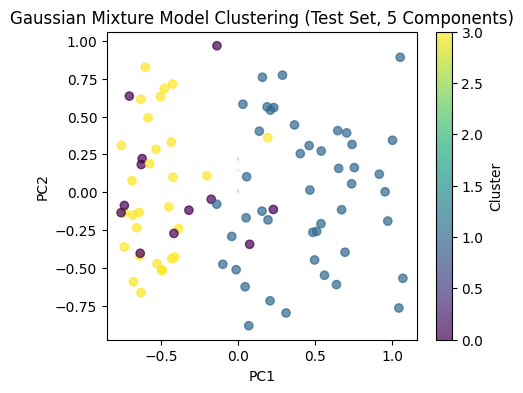

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import pandas as pd

df = pd.read_csv("/research/groups/bioinformaticians/internship/aalizade/Thesis/42Imeta.tsv", sep="\t")

columns = [
    "joint_3c", "joint_6c", "joint_7c", "joint_8c", "joint_11c",  
    "joint_12a", "joint_12b", "joint_14d", "joint_21b", "exp_3c", 
    "exp_6c", "exp_7c", "exp_8c", "exp_11c", "exp_12a", "exp_12b", "exp_14d", 
    "exp_21b", "allele_3c", "allele_6c", "allele_7c", "allele_8c", "allele_11c", "allele_12a", 
    "allele_12b", "allele_14d", "allele_21b"
]

X_train = df[columns]
X_valid = df[df["clone_opt"].isin(["1_2"])][columns]
X_test = df[df["clone_opt"] == "3_4"][columns]

n_components_range = range(1, 11) 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

bics = {n: [] for n in n_components_range}

for n_components in n_components_range:
    for train_index, valid_index in kf.split(X_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X_train_fold)
        
        bic = gmm.bic(X_valid_fold)
        bics[n_components].append(bic)

avg_bics = {n: np.mean(bics[n]) for n in n_components_range}

optimal_components_bic = min(avg_bics, key=avg_bics.get)
print(f"Optimal components (BIC): {optimal_components_bic}")

best_gmm = GaussianMixture(n_components=optimal_components_bic, random_state=42)
best_gmm.fit(X_train)

predicted_labels = best_gmm.predict(X_test)

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(5, 4))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predicted_labels, cmap='viridis', alpha=0.7)

for i in range(optimal_components_bic):
    mean = best_gmm.means_[i]
    covar = best_gmm.covariances_[i]
    
    v, w = np.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v) 
    u = w[0] / np.linalg.norm(w[0])
    
    angle = np.arctan2(u[1], u[0]) * 180 / np.pi 

    from matplotlib.patches import Ellipse
    ell = Ellipse(xy=mean[:2], width=v[0], height=v[1], angle=angle, color='r', alpha=0.3)
    plt.gca().add_patch(ell)

plt.title(f"Gaussian Mixture Model Clustering (Test Set, {optimal_components_bic} Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

In [2]:
predicted_labels = best_gmm.predict(X_test)
cell_assignments = pd.DataFrame({
    "Cell": X_test.index,
    "Cluster": predicted_labels
})
print(cell_assignments.head())
#cell_assignments.to_csv("42I_GMM.csv", index=False)

                 Cell  Cluster
0  AAAGTAGCATCCGGGT-1        1
1  AACTTTCCATCTACGA-1        3
2  AAGCCGCAGCTGAAAT-1        1
3  AAGTCTGAGTACGTAA-1        0
4  AATCCAGAGGCGCTCT-1        0
